In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [81]:
data1=pd.read_excel("gold2021.xlsx")
data2=pd.read_excel("gold2020.xlsx")
data3=pd.read_excel("gold2019.xlsx")
data4=pd.read_excel("gold2018.xlsx")

In [82]:
data=pd.concat([data1,data2,data3,data4])
data=data.sort_values(by='DATE', ascending=True)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data=data.set_index('DATE')

In [83]:
data

,Price
DATE,
2018-10-12,31876
2018-10-15,32264
2018-10-16,32109
2018-10-17,32043
2018-10-18,32037
...,...
2021-11-29,48042
2021-11-30,48085
2021-12-01,47633


## Seasonal Naive Model

In [84]:
from sklearn.model_selection import train_test_split

In [501]:
# separate out a validation dataset
split_point = len(data)-152
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 606, Validation 152


In [502]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate a persistence model
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [503]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=43076.000, Expected=42729.000
>Predicted=42729.000, Expected=42429.000
>Predicted=42429.000, Expected=42024.000
>Predicted=42024.000, Expected=42376.000
>Predicted=42376.000, Expected=42585.000
>Predicted=42585.000, Expected=42613.000
>Predicted=42613.000, Expected=42416.000
>Predicted=42416.000, Expected=42351.000
>Predicted=42351.000, Expected=42598.000
>Predicted=42598.000, Expected=42590.000
>Predicted=42590.000, Expected=42712.000
>Predicted=42712.000, Expected=42933.000
>Predicted=42933.000, Expected=43438.000
>Predicted=43438.000, Expected=43515.000
>Predicted=43515.000, Expected=43508.000
>Predicted=43508.000, Expected=45377.000
>Predicted=45377.000, Expected=44656.000
>Predicted=44656.000, Expected=44449.000
>Predicted=44449.000, Expected=44408.000
>Predicted=44408.000, Expected=44200.000
>Predicted=44200.000, Expected=43982.000
>Predicted=43982.000, Expected=44025.000
>Predicted=44025.000, Expected=45034.000
>Predicted=45034.000, Expected=45140.000
>Predicted=45140

### Time series decomposition

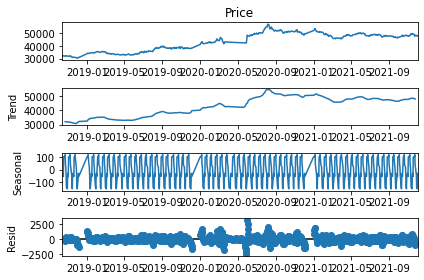

In [98]:
decompose_ts_add = seasonal_decompose(data.Price,period=12)
decompose_ts_add.plot()
plt.show()

In [166]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(17,12), 'figure.dpi':120})

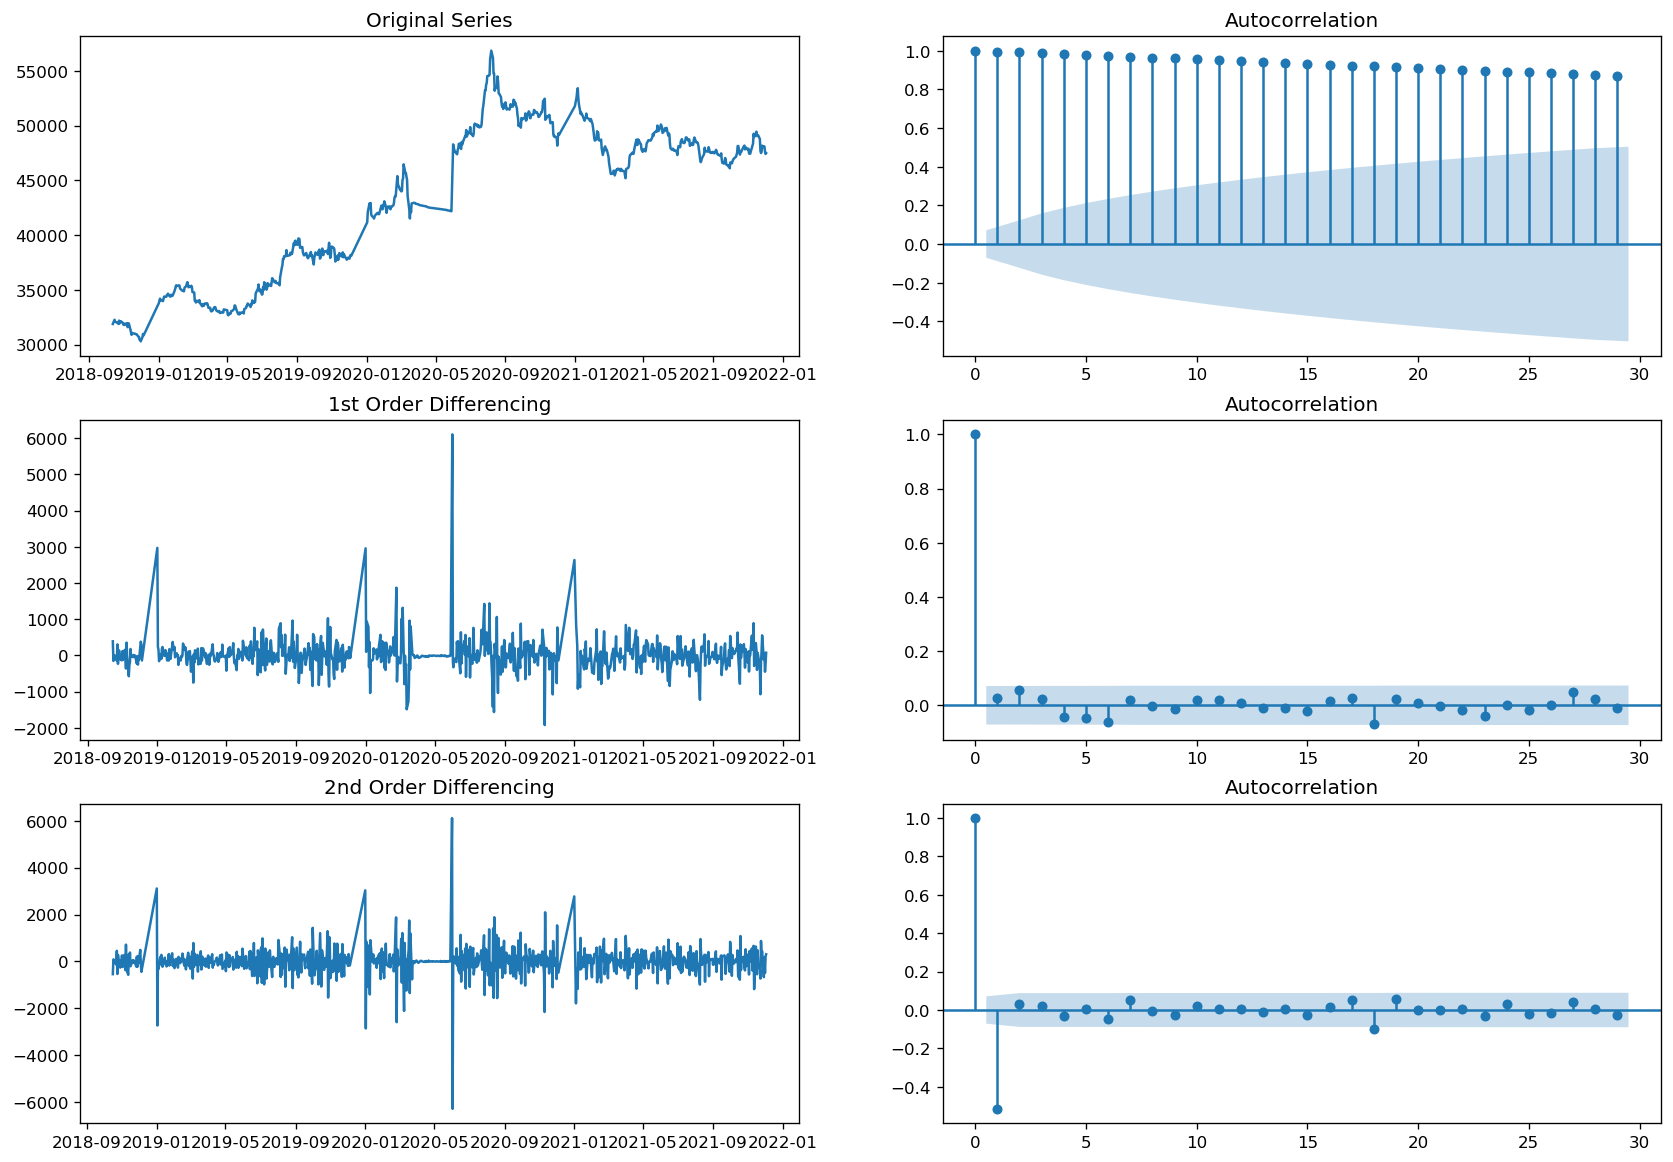

In [167]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(data.Price); axes[0, 0].set_title('Original Series')
plot_acf(data.Price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.Price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.Price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.Price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.Price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [168]:
#check number of difference required for a stationary series

from pmdarima.arima.utils import ndiffs
y = data.Price
## Adf Test
print('ADF :', ndiffs(y, test='adf') )
# KPSS test
print('KPSS :' ,ndiffs(y, test='kpss'))
# PP test:
print('PP :' ,ndiffs(y, test='pp'))


ADF : 1
KPSS : 1
PP : 1


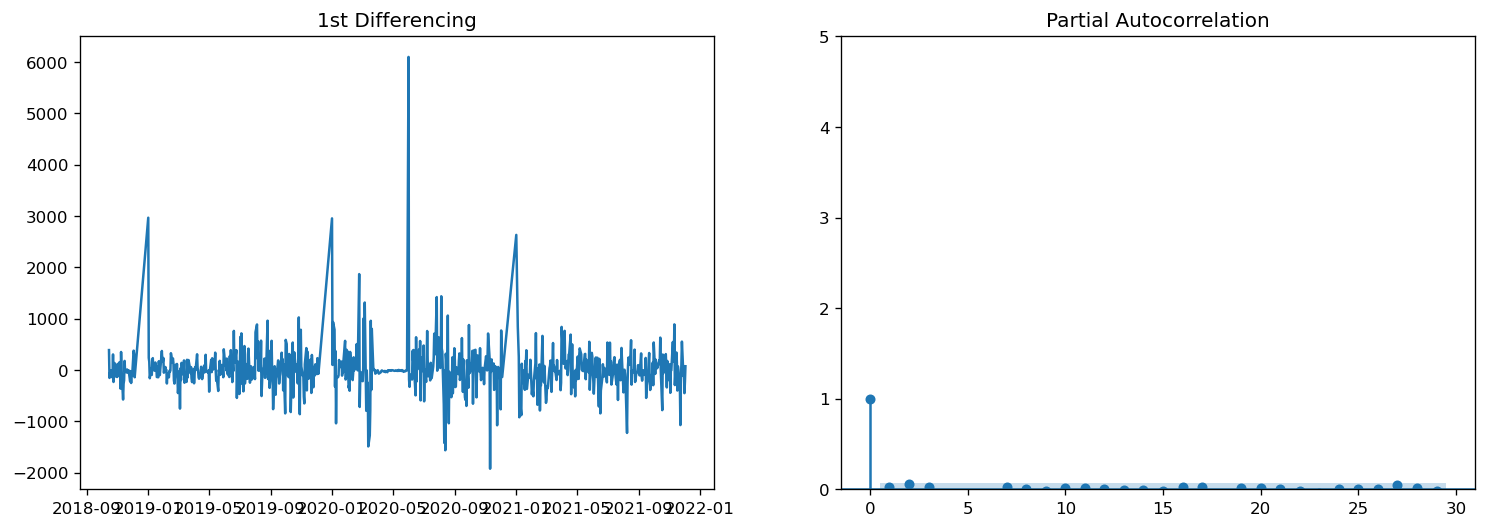

In [169]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(data.Price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.Price.diff().dropna(), ax=axes[1])

plt.show()

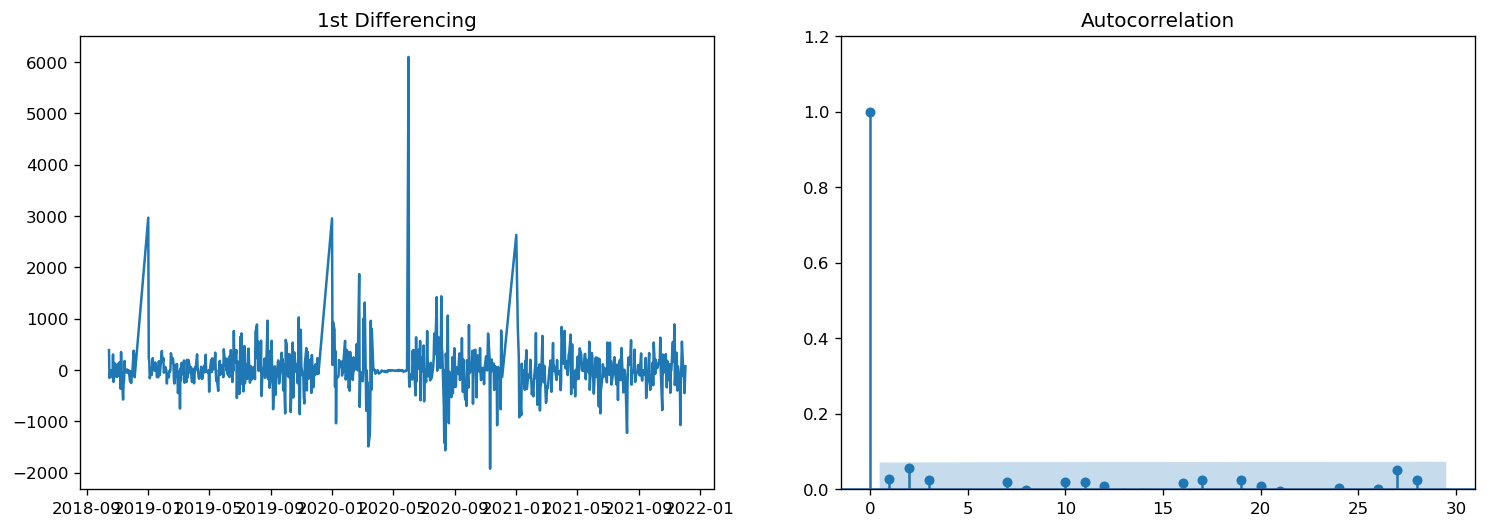

In [170]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(data.Price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.Price.diff().dropna(), ax=axes[1])

plt.show()

In [182]:
from statsmodels.tsa.arima_model import ARIMA

In [488]:
# separate out a validation dataset
split_point = len(data)-152
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 606, Validation 152


### ARIMA

In [491]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [496]:
# fit model
model = ARIMA(X, order=(0,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=152)[0]
#model_fit.plot_predict(1,758)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  604
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4596.079
Method:                           css   S.D. of innovations            488.072
Date:                Mon, 10 Jan 2022   AIC                           9196.157
Time:                        15:46:40   BIC                           9204.964
Sample:                             1   HQIC                          9199.584
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4570     19.859      1.282      0.200     -13.467      64.381
==============================================================================
"""

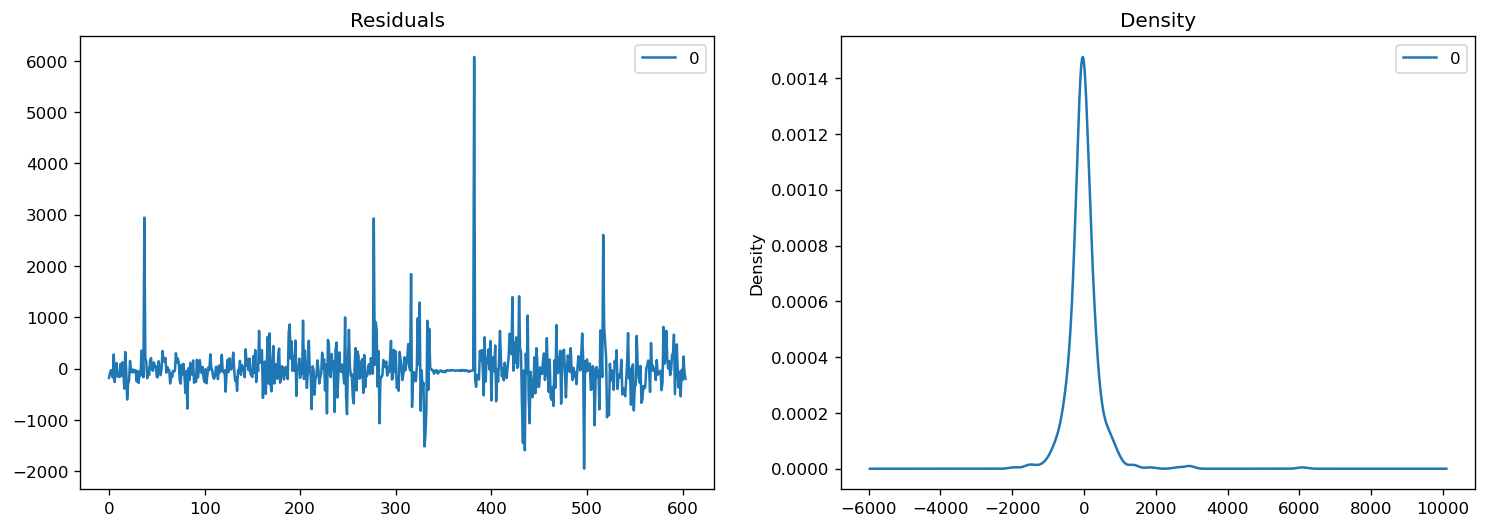

In [497]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

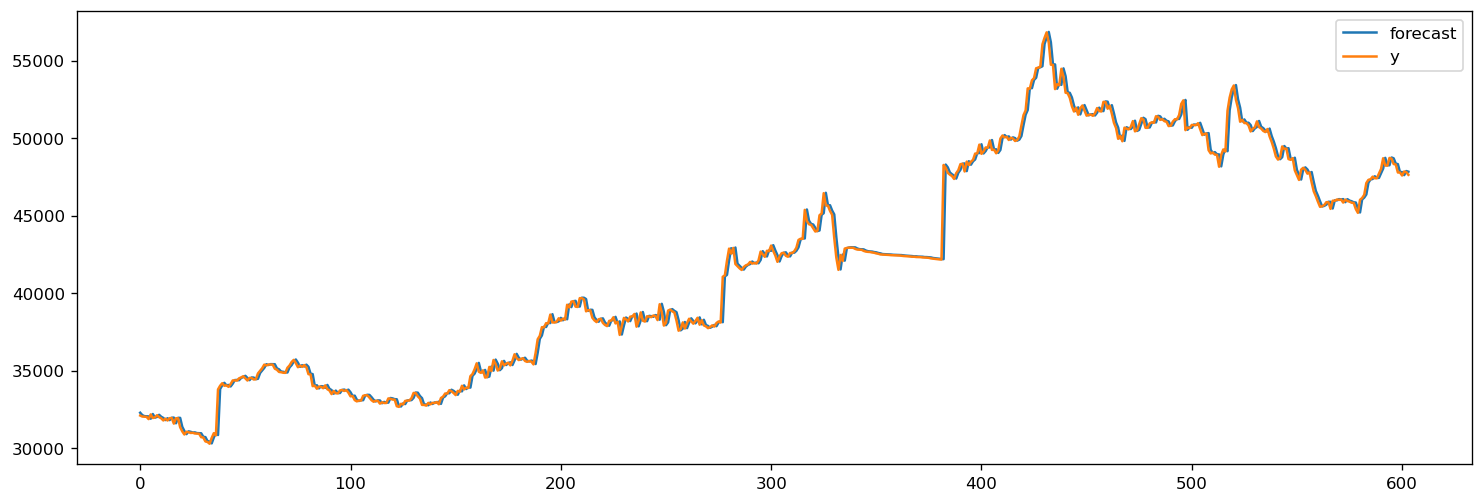

In [498]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [499]:
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

2313.362313799277

In [453]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = data.Price[:558].astype('float32')
test = data.Price[558:].astype('float32')

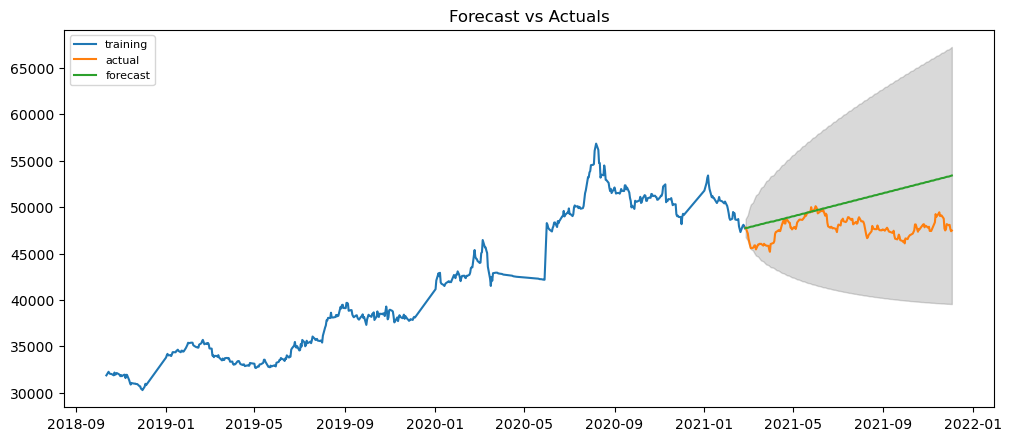

In [454]:
# Build Model
model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(200, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [455]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape*100, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1*100, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 5.930521768403676,
 'me': 2796.4992728903535,
 'mae': 2814.7450538598387,
 'mpe': 0.05893952766023237,
 'rmse': 3330.662778251744,
 'acf1': 97.14821848321061,
 'corr': 0.16652970213228716,
 'minmax': 0.05479185531632935}

In [456]:
import pmdarima as pm

model = pm.auto_arima(data.Price, start_p=1, start_q=1,
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11428.645, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11426.386, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11427.401, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11427.484, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11425.922, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.905 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  758
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5711.961
Date:                Mon, 10 Jan 2022   AIC                          11425.922
Time:                        15:31:57   BIC                          11430.551
Sample:                             0   HQIC                         11427.705
                                - 758                                  

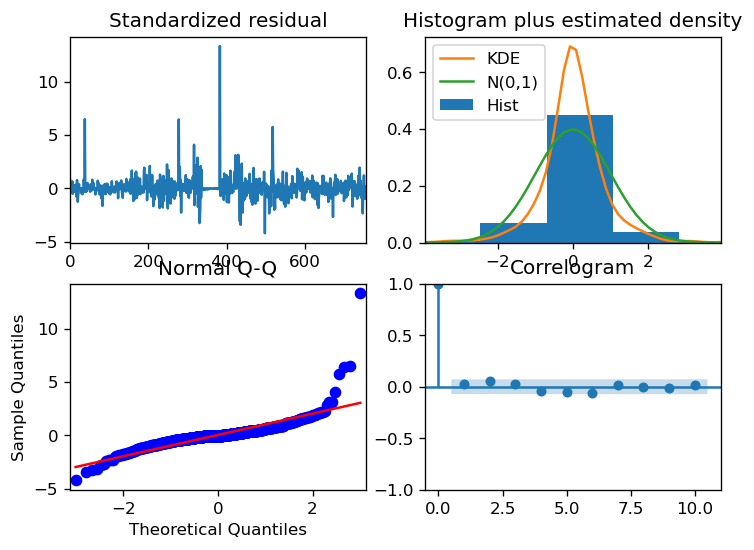

In [457]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

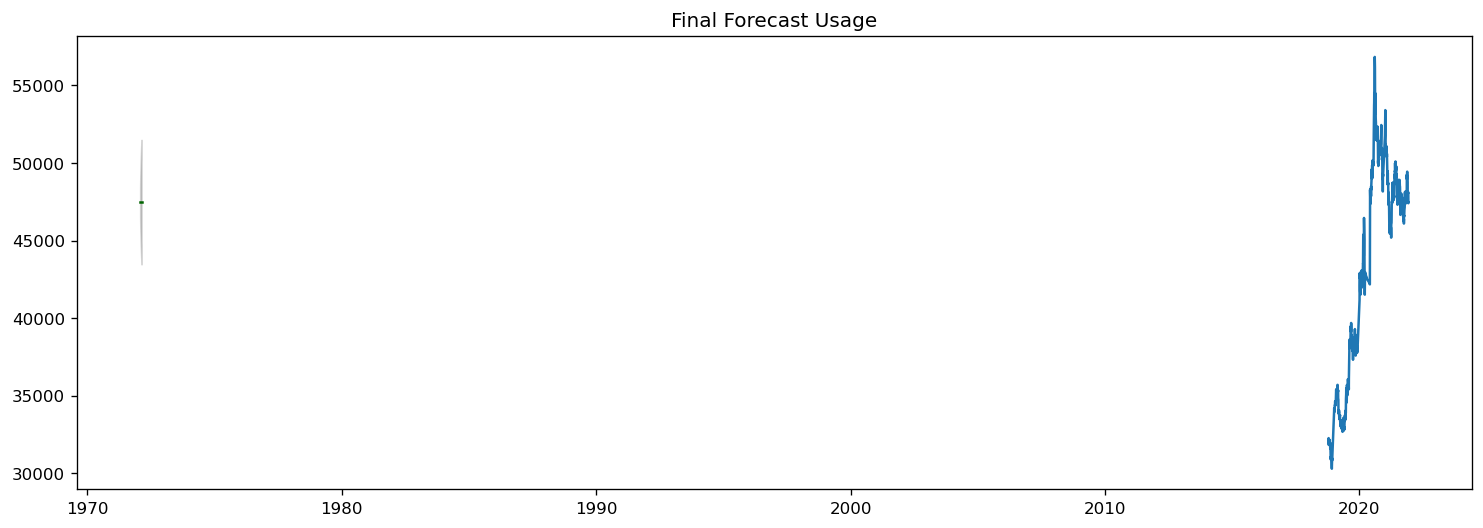

In [458]:
# Forecast
n_periods = 20
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data.Price), len(data.Price)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data.Price,)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast Usage")
plt.show()


### SARIMA

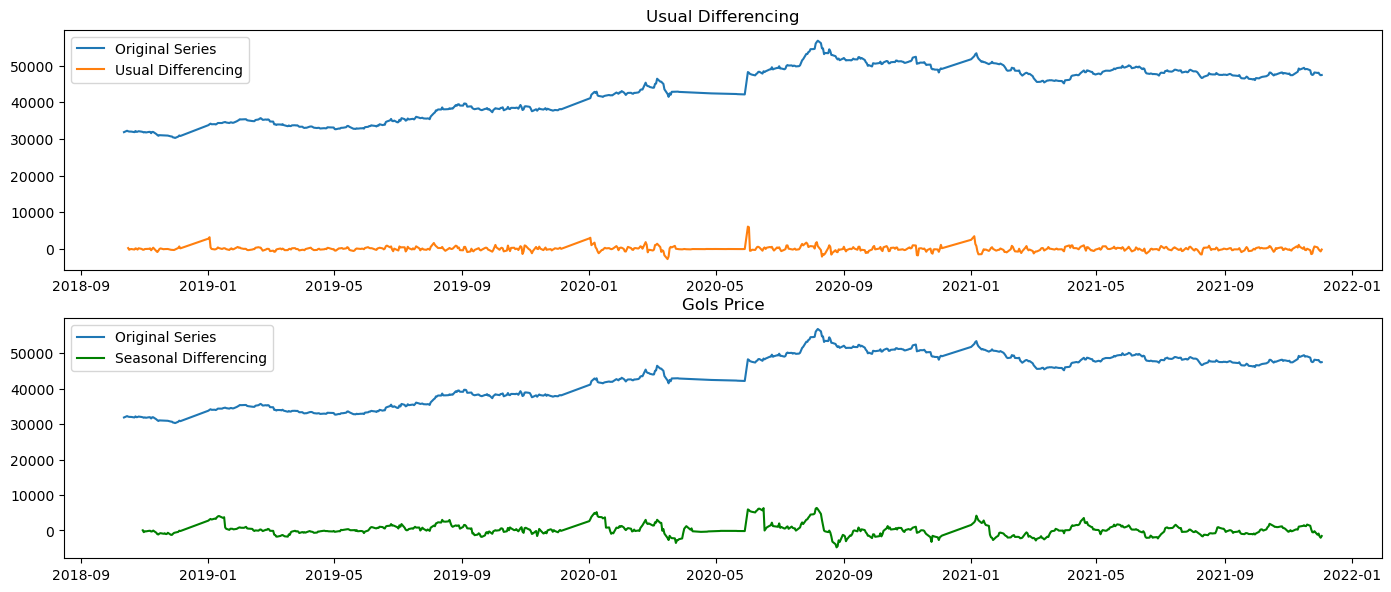

In [414]:

# Plot
fig, axes = plt.subplots(2, 1, figsize=(17,7), dpi=100)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(2), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Gols Price')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [415]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=12071.411, Time=8.75 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=13135.622, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=12099.122, Time=5.96 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=12534.239, Time=4.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=13152.612, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=12240.975, Time=3.01 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=12068.104, Time=2.75 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=12080.408, Time=7.61 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=12069.976, Time=19.14 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=12062.266, Time=29.44 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=12060.281, Time=16.62 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=12534.450, Time=14.43 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=12073.703, Time=27.80 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=12062.282, Time=30.54 sec

KeyboardInterrupt: 

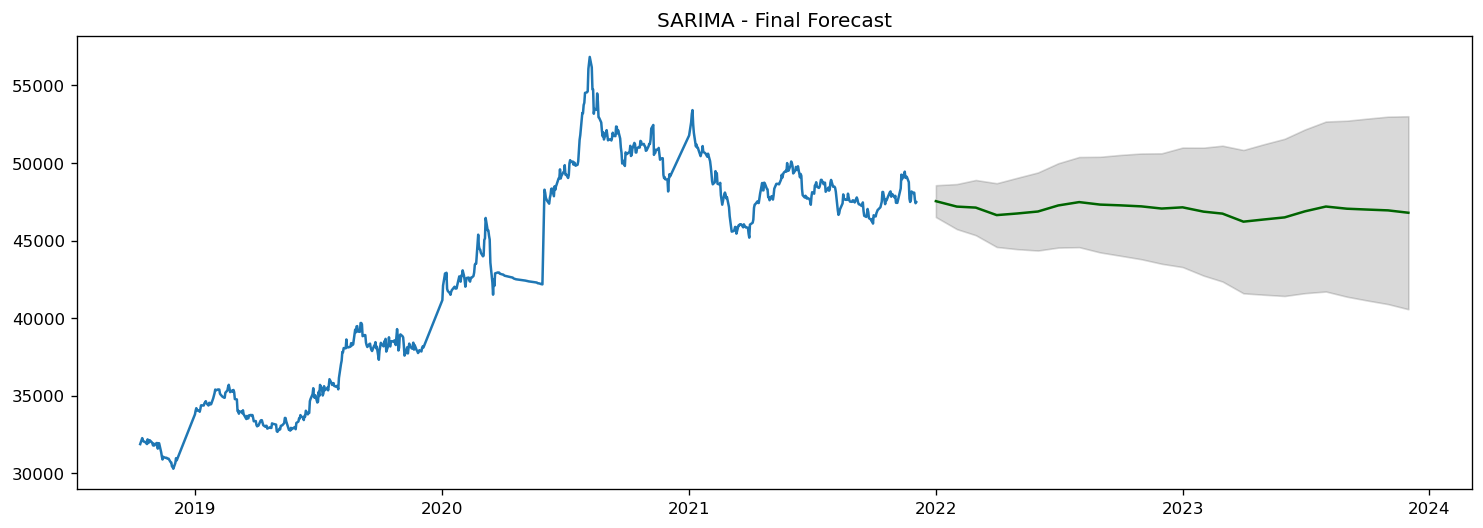

In [313]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()